In [92]:
import pickle
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
os.environ['DGLBACKEND'] = 'pytorch'
from dgl import DGLGraph
import numpy as np
import scipy.sparse as spp
from scipy import spatial
from dgl.data import DGLDataset
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from ApolloScape_Dataset import ApolloScape_DGLDataset


In [93]:
train_dataset = ApolloScape_DGLDataset(train_val='train')
val_dataset = ApolloScape_DGLDataset(train_val='val')

In [85]:
# Collate function to prepare graphs
def collate_batch(samples):
    graphs, masks = map(list, zip(*samples))  # samples is a list of pairs (graph, mask) mask es VxTx1
    masks = torch.tensor(masks).squeeze(0)
    sizes_n = [graph.number_of_nodes() for graph in graphs] # graph sizes
    snorm_n = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_n]
    snorm_n = torch.cat(snorm_n).sqrt()  # graph size normalization 
    sizes_e = [graph.number_of_edges() for graph in graphs] # nb of edges
    snorm_e = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_e]
    snorm_e = torch.cat(snorm_e).sqrt()  # graph size normalization
    batched_graph = dgl.batch(graphs)  # batch graphs
    return batched_graph.to(dev), masks.to(dev), snorm_n, snorm_e

In [94]:
train_dataloader=DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)
val_dataloader=DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)


In [5]:
with open('../DBU_Graph/data/apollo_train_data.pkl', 'rb') as reader:
    [feat,adj, mean]=pickle.load(reader)
    
feat=np.transpose(feat, (0,3,2,1))
print(adj.shape)

(5010, 120, 120)


In [10]:
'''
#pruebas def preprocess_data de main.py (GRIP) 
feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
vel_data = feat[:,feature_id]  # N,C,T,V
vel_mask = (vel_data[:, :2, 1:]!=0) * (vel_data[:, :2, :-1]!=0) #False-> frames en los que no tenemos VELOCIDAD del obj
vel_data[:, :2, 1:] = (vel_data[:, :2, 1:] - vel_data[:, :2, :-1]).astype(float) * vel_mask.astype(float)
vel_data[:, :2, 0] = 0
print(vel_data[0,:,6:,0])
#print(new_mask[0,:,:,0])
'''


[[ 1.  1. -0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 6.  7.  8.  9. 10. 11.]
 [ 6.  7.  8.  9. 10.  0.]]


In [6]:

last_vis_obj=[]   #contains number of visible obj in each sequence of the training

for idx in range(len(adj)): 
    for i in range(len(adj[idx])): 
        if adj[idx][i,i] == 0:
            last_vis_obj.append(i)
            break   
            
last_vis_obj


[13,
 14,
 15,
 15,
 17,
 23,
 24,
 25,
 24,
 25,
 22,
 21,
 21,
 24,
 24,
 27,
 25,
 24,
 25,
 25,
 28,
 29,
 31,
 32,
 32,
 31,
 46,
 44,
 41,
 42,
 43,
 42,
 41,
 39,
 36,
 33,
 29,
 27,
 20,
 17,
 16,
 15,
 14,
 16,
 15,
 15,
 14,
 18,
 16,
 15,
 16,
 18,
 17,
 18,
 18,
 19,
 18,
 17,
 17,
 18,
 19,
 20,
 21,
 20,
 20,
 19,
 17,
 16,
 15,
 14,
 15,
 20,
 20,
 20,
 22,
 21,
 21,
 22,
 21,
 20,
 20,
 22,
 22,
 20,
 21,
 19,
 20,
 22,
 21,
 20,
 17,
 17,
 15,
 16,
 16,
 15,
 19,
 19,
 17,
 18,
 18,
 18,
 18,
 18,
 20,
 20,
 17,
 19,
 18,
 10,
 10,
 7,
 5,
 5,
 5,
 5,
 7,
 7,
 7,
 11,
 12,
 12,
 16,
 16,
 14,
 15,
 18,
 19,
 19,
 20,
 22,
 20,
 20,
 21,
 22,
 20,
 22,
 21,
 19,
 16,
 14,
 13,
 15,
 15,
 17,
 18,
 20,
 18,
 19,
 25,
 24,
 24,
 28,
 26,
 24,
 22,
 22,
 20,
 19,
 17,
 14,
 13,
 13,
 13,
 11,
 10,
 8,
 6,
 5,
 4,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 4,
 3,
 2,
 7,
 12,
 13,
 16,
 17,
 17,
 17,
 15,
 15,
 12,
 12,
 12,
 13,
 12,
 12,
 13,
 13,
 13,
 14,
 14,
 13,
 13,
 14,
 11,
 12

In [7]:
features=torch.from_numpy(feat[:,:70,:,:]).type(torch.float32)
print(features.shape)


torch.Size([5010, 70, 12, 11])


(tensor([ 0,  0,  1,  1,  2,  2,  2,  2,  3,  4,  5,  5,  5,  5,  5,  6,  6,  7,
         7,  7,  7,  7,  8,  8,  8,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 12,
        12, 12, 12]), tensor([ 0,  6,  1,  2,  1,  2,  8,  9,  3,  4,  5,  7,  9, 11, 12,  0,  6,  5,
         7, 10, 11, 12,  2,  8,  9,  2,  5,  8,  9,  7, 10,  5,  7, 11, 12,  5,
         7, 11, 12]))


<IPython.core.display.Javascript object>


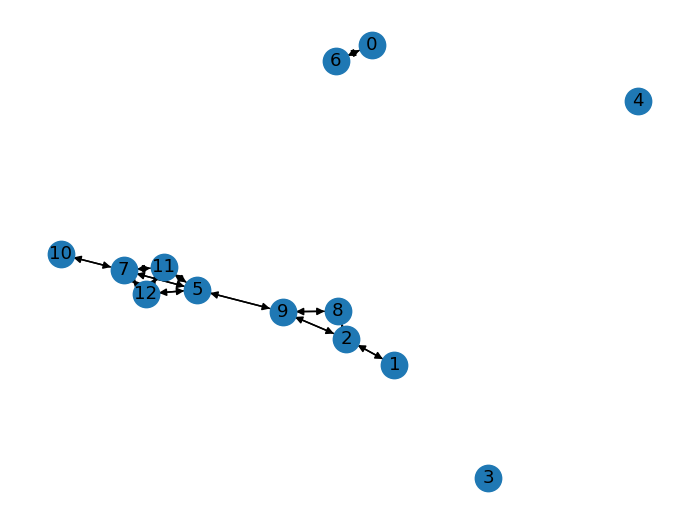

In [10]:
%matplotlib notebook
graph=dgl.DGLGraph(spp.coo_matrix(adj[0][:13,:13]))
print(graph.edges())
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

<IPython.core.display.Javascript object>


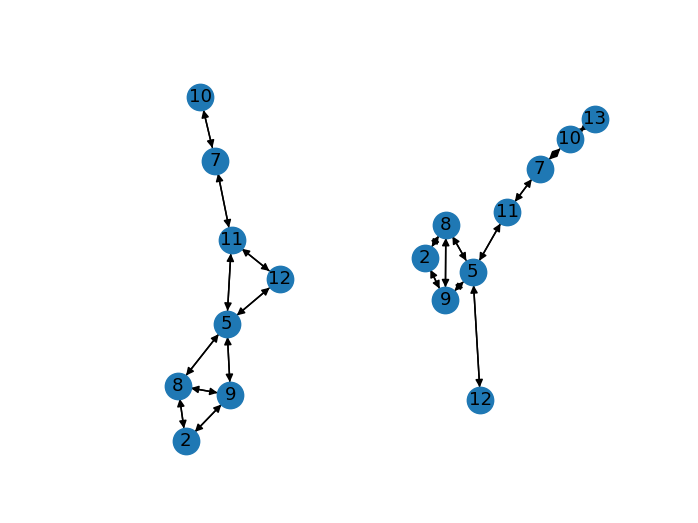

In [12]:
%matplotlib notebook

plt.subplot(1,2,1)
graph=dgl.DGLGraph(spp.coo_matrix(adj[1][:last_vis_obj[1],:last_vis_obj[1]]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.subplot(1,2,2)
graph=dgl.DGLGraph(spp.coo_matrix(adj[2][:last_vis_obj[2],:last_vis_obj[2]]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

### PREPROCESS DATA

### Crear grafo (Ejemplo secuencia 0)
Para el entrenamiento iterar sobre todas las secuencias

In [8]:
now_history_frame=6
object_type = features[:,:,:,2].int()  # torch Tensor NxVxT
#vis_obj_type=np.zeros((features.shape[0],features.shape[1])) #NxV
mask_car=np.zeros((features.shape[0],features.shape[1],now_history_frame)) #NxVx6
for i in range(len(features)):
    #vis_obj_type[i,:] =object_type[i,:,5] #Append Vx1 #tipos de obj visibles de la primera seq    
    mask_car_t=np.array([1  if (j==2 or j==1) else 0 for j in object_type[i,:,5]])  #1 si obj 1/2 en frame 5 (size V)
    mask_car[i,:]=np.array(mask_car_t).reshape(mask_car.shape[1],1)+np.zeros(6) #Vx6 mask para los 6 output frames que indican si el obj es visible y car

#COMPROBADO OK

In [9]:

feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
#120 agentes (13 visibles -> feat[11]=1) y 12 frames (si no hay info en alguno de os 12 frames: fila nula)
node_features = features[:,:,:now_history_frame,feature_id]  #obj type,x,y 6 primeros frames
node_labels=features[:,:,now_history_frame:,3:5] #x,y 6 ultimos frames
node_features[:,:,:,-1] *= mask_car   #Pongo 0 en feat 11 [mask] a todos los obj visibles no-car
node_labels[:,:,:,-1] *= mask_car
output_mask= features[:,:,6:,-1]*mask_car #mascara obj (car) visibles en 6º frame (5010,120,6)
output_mask.unsqueeze_(-1).type(torch.uint8)    #N,V,T,1                  

print(node_features.shape, node_labels.shape,output_mask.shape)

torch.Size([5010, 70, 6, 4]) torch.Size([5010, 70, 6, 2]) torch.Size([5010, 70, 6, 1])


In [10]:
zero_indeces_list = [i for i in range(len(output_mask)) if np.all(np.array(output_mask.squeeze(-1))==0, axis=(1,2))[i] == True ]
zero_indeces_list

[51,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 288,
 289,
 290,
 298,
 299,
 300,
 301,
 311,
 312,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 363,
 364,
 365,
 366,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1191,
 1192,
 1193,
 1194,
 1195,
 1196,
 1197,
 1198,
 1199,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1221,
 1222,
 1223,
 1224,
 1225,
 1226,
 1227,
 1231,
 1232,
 1233,
 1244,
 1245,
 1246,
 1247,
 1248,
 1249,
 1270,
 1

In [11]:
zero_maskcar_list = [i for i in range(len(mask_car)) if np.all(np.array(mask_car)==0, axis=(1,2))[i] == True ]
len(zero_maskcar_list) #374

374

In [12]:
total_num = len(features)
id_list = list(set(list(range(total_num))) - set(zero_indeces_list))
total_valid_num = len(id_list) #4596
ind=np.random.permutation(id_list)
train_id_list, val_id_list = ind[:round(total_valid_num*0.8)], ind[round(total_valid_num*0.8):]


'''
train_id_list = list(np.linspace(0, total_valid_num-1, int(total_valid_num*0.8)).astype(int))
val_id_list = list(set(list(range(total_valid_num))) - set(train_id_list))  

if train_val_test.lower() == 'train':
    self.all_feature = self.all_feature[train_id_list]
    self.all_adjacency = self.all_adjacency[train_id_list]
    self.all_mean_xy = self.all_mean_xy[train_id_list]
elif train_val_test.lower() == 'val':
    self.all_feature = self.all_feature[val_id_list]
    self.all_adjacency = self.all_adjacency[val_id_list]
    self.all_mean_xy = self.all_mean_xy[val_id_list]
'''
print(len(train_id_list)) #3677

3677


In [13]:
xy_dist=[spatial.distance.cdist(node_features[i][:,5,:], node_features[i][:,5,:]) for i in range(len(features))]  #5010x120x120

In [11]:
####PESOS EN EDGES
#120x120 -> solo quiero los que tengan 1 en Adj[0] (máscara) aka 39 valores
#Obtener las 39 distancias correspondientes a cada edge
distances = [xy_dist[0][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
print(len(distances))
norm_distances = [(i-min(distances))/(max(distances)-min(distances)) for i in distances]
norm_distances = [1/(i) if i!=0 else 1 for i in distances]
print(norm_distances)
#NORMALIZAR ENTRE 0 Y 1
graph.edata['w']=torch.tensor(norm_distances, dtype=torch.float32)

NameError: name 'graph' is not defined

### Convolutional Layer 

In [14]:
import dgl.function as fn
#Perform message passing and then apply fc Layer (self-loops! - same W for neighbors and itself)
# Traditional GCN:
#fn.copy_src(src='h', out='m')
#gcn_reduce = fn.sum(msg='m', out='h')
# multiply source node features with edge weights and aggregate them in destination nodes
gcn_msg=fn.u_mul_e('h', 'w', 'm') #elemnt-wise (broadcast)
gcn_reduce = fn.sum(msg='m', out='h')
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear = nn.Linear(in_feats, out_feats)
        
    def reduce_func(self, nodes):
        h = torch.sum(nodes.mailbox['m'], dim=1)
        return {'h': h}

    def forward(self, g, feature,e_w, snorm_n, snorm_e):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            
            g.ndata['h_s']=self.linear_self(feature)
            
            #normalization
            degs = g.out_degrees().float().clamp(min=1)
            norm=torch.pow(degs,-0.5)
            shp = norm.shape + (1,)*(feature.dim() -1)
            norm = torch.reshape(norm,shp)
            feature = feature*norm
            
            #aggregate
            g.edata['w'] = e_w
            g.ndata['h'] = feature
            g.update_all(gcn_msg, self.reduce_func)
            
            #mult W and normalization
            h = self.linear(g.ndata['h'])
            degs = g.in_degrees().float().clamp(min=1)
            norm = torch.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feature.dim() - 1)
            norm = torch.reshape(norm, shp)
            h = h * norm
            
            h = g.ndata['h_s'] + h #Vx6xout_feats
            
            #h = h * (torch.ones_like(h)*snorm_n)  # normalize activation w.r.t. graph node size
            #e_w =  e_w * (torch.ones_like(e_w)*snorm_e)  # normalize activation w.r.t. graph edge size
            e_w =  e_w
            
            return h, e_w

In [16]:
#Prueba forward pass en gcn con un grafo OK
#model = GCN(in_feats=4, hid_feats=64, out_feats=2)
#model(graph, graph.ndata['x'],graph.edata['w'])

In [29]:
from dgl.nn import GatedGraphConv, GraphConv, GATConv,SAGEConv

conv = GraphConv(4,2, weight=True, bias=True)
#sageconv = SAGEConv(4,2,aggregator_type='lstm')
#gated_conv = GatedGraphConv(4, 2, 2, 3)
#gatconv=GATConv(4,2,num_heads=4)
graph = dgl.add_self_loop(graph)   #Añado selfloops pq no puede haber zero in-degree nodes
res = conv(graph, node_features[0])
print(res.shape)

torch.Size([70, 6, 2])


### Graph Convolutional Model

In [15]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = GCNLayer(in_feats=in_feats, out_feats=hid_feats)
        self.conv2 = GCNLayer(in_feats=hid_feats, out_feats=out_feats)
        self.fc= nn.Linear(out_feats,out_feats)
    def forward(self, graph, inputs,e_w,snorm_n, snorm_e):
        #inputs are features of nodes
        h,e_w = self.conv1(graph, inputs,e_w,snorm_n, snorm_e) #Vx6x4 -> Vx6x32  
        h = F.relu(h)
        h,_ = self.conv2(graph,h,e_w,snorm_n, snorm_e)  #Vx6x2  
        y = self.fc(h)
        return y
        

### GAT Layer

In [16]:
class My_GATLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GATLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear_func = nn.Linear(in_feats, out_feats, bias=False)
        self.attention_func = nn.Linear(2 * out_feats, 1, bias=False)
        
    def edge_attention(self, edges):
        concat_z = torch.cat([edges.src['z'], edges.dst['z']], dim=1).sum(dim=0) #(6,2)||(6,2) -> (6,4) -> (4)
        src_e = self.attention_func(concat_z)  #(1) att logit
        src_e = F.leaky_relu(src_e)
        return {'e': src_e}
    
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e':edges.data['e']}
        
    def reduce_func(self, nodes):
        h_s = nodes.data['h_s']
        a = F.softmax(nodes.mailbox['e'], dim=1)   #attention score between nodes i and j
        h = h_s + torch.sum(a * nodes.mailbox['z'], dim=1)
        return {'h': h}
                               
    def forward(self, graph, h):
        h_in = h
        g.ndata['h']  = h 
        g.ndata['h_s'] = self.linear_self(h) 
        g.ndata['z'] = self.linear_func(h) #(6,4) -> (6,2) infeats=4 outfeats=2
        graph.apply_edges(self.edge_attention)
        graph.update_all(self.message_func, self.reduce_func)
        h = g.ndata['h'] # result of graph convolution
        #h = h * snorm_n # normalize activation w.r.t. graph node size
        #h = self.bn_node_h(h) # batch normalization 
        h = torch.relu(h) # non-linear activation
        h = h_in + h # residual connection
        return h #graph.ndata.pop('h')


class MultiHeadGATLayer(nn.Module):
    def __init__(self, in_feats, out_feats, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(My_GATLayer(in_dim, out_dim))
        self.merge = merge

    def forward(self, g, h):
        head_outs = [attn_head(g, h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1), for intermediate layers
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average, for final layer
            return torch.mean(torch.stack(head_outs))

In [ ]:
class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, input_dim) 
        self.layer2 = nn.Linear(input_dim, output_dim) 
        
    def forward(self, x):
        y = x
        y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

In [17]:
class My_GAT(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.gat_1 = GATLayer(hidden_dim, hidden_dim)
        self.gat_2 = GATLayer(hidden_dim, hidden_dim)
        #self.gat_1 = MultiHeadGATLayer(hidden_dim, hidden_dim, heads)
        #self.gat_2 = MultiHeadGATLayer(hidden_dim*heads, hidden_dim, 1)
        self.linear1 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)  #input (6,4) - (6,32)
        
        # gat layers
        h = F.relu(self.gat_1(g, h))
        h = F.relu(self.gat_2(g, h))
        
        y = self.linear1(h)  # (6,32) -> (6,2)
        
        return y

### TRAINING Tests

#### Collate function to prepare graphs

In [18]:
def compute_RMSE(pred, gt, mask): 
    #output mask vale 0 si no visible o no-car o visible pero no hay datos en ese frame  (70,6,1)
    pred = pred*mask #Con esto ya quito del error aquellas filas donde no tengo datos.
    gt = gt*mask  #120 nodos outputmask V,T,C
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=2) #V,T 
    overall_sum_time = x2y2_error.sum(dim=0).requires_grad_()  #T - suma de los errores de los V agentes
    overall_num = mask.sum(dim=-1).sum(dim=0).type(torch.int) #torch.Tensor[(T)] - num de agentes en cada frame
    return overall_sum_time, overall_num, x2y2_error



In [19]:
def compute_RMSE_batch(pred, gt, mask): 
    #output mask vale 0 si no visible o no-car o visible pero no hay datos en ese frame  (B*)V,T,1
    pred = pred*mask #B*V,T,C  (B n grafos en el batch)
    gt = gt*mask  # outputmask BV,T,C
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) #BV,T 
    overall_sum_time = x2y2_error.sum(dim=-2)  #B,T - suma de los errores de los V agentes
    overall_num = mask.sum(dim=-1).sum(dim=-2).type(torch.int) #torch.Tensor[(T)] - num de agentes en cada frame
    return overall_sum_time, overall_num, x2y2_error



In [42]:
from tqdm import tqdm

dev = 'cuda'
model = GCN(in_feats=4, hid_feats=32, out_feats=2).to(dev)
#model = My_GAT(input_dim=4, hidden_dim=64, output_dim=2)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
def err_handler(type, flag):
    print("Floating point error (%s), with flag %s,iter %d" % (type, flag, i))
np.seterrcall(err_handler)
np.seterr(all='raise')
for epoch in range(20):
    print('Epoch: ',epoch)
    overall_loss_train=[]
    overall_loss_val=[]
    model.train()
    for i in tqdm(train_id_list):
        graph = dgl.from_scipy(spp.coo_matrix(adj[i][:last_vis_obj[i],:last_vis_obj[i]])).int().to(dev)
        snorm_n, snorm_e, norm_d = collate(graph)
        #graph = dgl.remove_self_loop(graph)
        #graph = dgl.add_self_loop(graph)
        distances = [xy_dist[i][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
        norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
        norm_distances = [1/(i) if i!=0 else 1 for i in distances]
        e_w=torch.tensor(norm_distances, dtype=torch.float32).to(dev)
        #forward prop by using all nodes
        pred = model(graph, node_features[i,:last_vis_obj[i]].to(dev),e_w,snorm_n, snorm_e)  #pred 120x6x2 , output mask 120x6x1
        #compute loss
        overall_sum_time, overall_num, _ = compute_RMSE(pred, node_labels[i,:last_vis_obj[i]].to(dev), output_mask[i,:last_vis_obj[i]].to(dev))
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num)#torch.max(torch.sum(overall_num).type(torch.int), torch.ones(1,).type(torch.int).to(dev))    
        opt.zero_grad() 
        total_loss.backward()
        opt.step()
        overall_loss_train.extend([total_loss.detach().cpu().numpy().sum(axis=0)])
    #print('|{}| Train_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_train) + [np.sum(overall_loss_train)]])))
    print('|{}| Train_loss: {}, len:{}'.format(datetime.now(), np.sum(overall_loss_train), len(overall_loss_train)))

    model.eval()
    with torch.no_grad():
        for i in val_id_list:
            graph = dgl.from_scipy(spp.coo_matrix(adj[i][:last_vis_obj[i],:last_vis_obj[i]])).int().to(dev)
            snorm_n, snorm_e, norm_d = collate(graph)
            #graph = dgl.remove_self_loop(graph)
            #graph = dgl.add_self_loop(graph)
            distances = [xy_dist[i][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
            norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
            norm_distances = [1/(i) if i!=0 else 1 for i in distances]
            e_w=torch.tensor(norm_distances, dtype=torch.float32).to(dev)
            
            #forward prop by using all nodes
            pred = model(graph, node_features[i,:last_vis_obj[i]].to(dev),e_w,snorm_n, snorm_e)
            _, overall_num, x2y2_error = compute_RMSE(pred, node_labels[i,:last_vis_obj[i]].to(dev), output_mask[i,:last_vis_obj[i]].to(dev))
            x2y2_error=x2y2_error.detach().cpu().numpy().sum(axis=0)
            overall_sum_time = np.sum(x2y2_error**0.5, axis=0)  #suma del error de todos los agentes en los T frames
            overall_num_time = np.sum(overall_num.detach().cpu().numpy(), axis=0) #numero de agentes en los T frames
            overall_loss_val.extend([overall_sum_time / (overall_num_time)]) #media del error de cada agente en los T frames
            
    print('|{}| Val_loss: {}, len:{}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_val) + [np.sum(overall_loss_val)]]), len(overall_loss_val)))


  0%|          | 5/3677 [00:00<01:20, 45.72it/s]

Epoch:  0


100%|██████████| 3677/3677 [01:02<00:00, 58.47it/s]


|2020-11-10 08:26:11.657242| Train_loss: 2034776.9557352923, len:3677


IndexError: Replacement index 2 out of range for positional args tuple

In [21]:
# Collate function to prepare graphs
def collate(graph):
    snorm_n = (1 / graph.number_of_nodes())**0.5  # graph size normalization 
    snorm_e = (1 / graph.number_of_edges())**0.5 # graph size normalization
    norm_d = torch.pow(graph.in_degrees().float(),-0.5)
    norm_d[torch.isinf(norm_d)]=0  #size [n_nodes]
    return snorm_n, snorm_e, norm_d

In [96]:
from tqdm import tqdm

dev='cuda'
model = GCN(in_feats=4, hid_feats=32, out_feats=2).to(dev)
#model = My_GAT(input_dim=4, hidden_dim=64, output_dim=2)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
np.seterr(all='raise')

for epoch in range(20):
    print('Epoch: ',epoch)
    overall_loss_train=[]
    overall_loss_val=[]
    model.train()
    overall_loss_train=[]
    overall_loss_val=[]    
    for batched_graph, output_masks,snorm_n, snorm_e in tqdm(train_dataloader):
        feats = batched_graph.ndata['x'].float().to(dev)
        e_w = batched_graph.edata['w'].float().to(dev)
        labels= batched_graph.ndata['gt'].float().to(dev)
        pred = model(batched_graph, feats,e_w,snorm_n,snorm_e)   #70,6,2
        
        overall_sum_time, overall_num, _ = compute_RMSE_batch(pred, labels, output_masks)  #(B,6)
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num) #valores similares
        opt.zero_grad() 
        total_loss.backward()
        opt.step()
        overall_loss_train.extend([total_loss.detach().cpu().numpy().sum(axis=0)])
       
    #print('|{}| Train_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_train) + [np.sum(overall_loss_train)]])))
    print('|{}| Train_loss: {}, len: {}'.format(datetime.now(), np.sum(overall_loss_train),len(overall_loss_train)))

    model.eval()
    with torch.no_grad():
               
        for batched_graph, output_masks,snorm_n, snorm_e in tqdm(val_dataloader):
            feats = batched_graph.ndata['x'].float().to(dev)
            e_w = batched_graph.edata['w'].float().to(dev)
            labels= batched_graph.ndata['gt'].float().to(dev)
            pred = model(batched_graph, feats,e_w,snorm_n,snorm_e)
            _, overall_num, x2y2_error = compute_RMSE_batch(pred, labels, output_masks)
            #print(x2y2_error.shape)  1,70,2
            x2y2_error=x2y2_error.detach().cpu().numpy().sum(axis=0)  #BV,T -> T
            overall_sum_time = np.sum(x2y2_error**0.5, axis=0)  #suma del error de todos los agentes en los T frames
            overall_num_time = np.sum(overall_num.detach().cpu().numpy(), axis=0) #numero de agentes en los T frames
            overall_loss_val.extend([overall_sum_time / overall_num_time]) #media del error de cada agente en los T frames
            
    print('|{}| Val_loss: {}, len:{}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_val) + [np.sum(overall_loss_val)]]), len(overall_loss_val)))


  0%|          | 7/3677 [00:00<01:00, 60.85it/s]

Epoch:  0


  1%|          | 8/919 [00:00<00:11, 79.28it/s]

|2020-11-10 08:52:30.104628| Train_loss: 8207006.467961508, len: 3677


  0%|          | 7/3677 [00:00<00:54, 67.83it/s]

|2020-11-10 08:52:42.132161| Val_loss: 5.608 5.016 9.543 8.932 2.852 12.729 7.580 2.844 15.838 14.117 17.958 15.968 11.300 12.879 12.917 2.268 9.097 11.205 6.600 6.728 9.689 9.010 17.531 7.988 8.715 6.892 6.997 9.292 11.185 6.199 7.365 7.419 9.018 10.360 22.621 13.762 18.430 10.936 30.606 6.105 15.417 11.185 7.960 18.804 6.484 2.583 6.407 15.849 17.973 8.728 6.479 9.430 8.914 6.750 8.506 8.581 11.108 16.623 16.180 6.781 11.547 6.035 17.035 9.846 6.111 9.400 10.785 13.115 18.707 11.274 6.777 13.858 8.775 5.941 14.909 7.786 4.565 13.316 16.405 6.091 5.174 5.475 14.417 13.629 12.765 16.862 18.737 19.060 19.523 6.084 4.057 39.073 10.117 16.059 9.968 9.963 14.136 3.786 8.140 20.700 20.312 9.635 15.102 6.750 5.587 5.575 4.761 15.104 6.578 28.497 16.428 4.893 12.471 3.911 28.751 15.971 21.686 7.250 13.200 19.610 9.724 4.144 7.204 10.659 3.771 9.304 22.627 15.732 9.099 10.699 19.453 25.739 23.749 25.712 12.170 7.961 5.237 9.333 20.438 9.628 14.917 5.106 7.457 1.489 10.915 7.563 10.535 7.622 6.

  1%|          | 9/919 [00:00<00:10, 87.57it/s]

|2020-11-10 08:53:40.824977| Train_loss: 2640701.1503667063, len: 3677


  0%|          | 7/3677 [00:00<00:53, 68.24it/s]

|2020-11-10 08:53:52.820099| Val_loss: 5.573 4.847 9.419 8.850 2.874 12.706 7.486 2.850 15.817 14.015 17.684 15.800 11.249 12.869 12.726 2.646 9.006 11.207 6.712 6.333 9.595 8.814 17.233 7.983 7.485 6.846 6.852 9.176 10.588 5.988 7.361 7.356 9.033 10.439 23.158 13.556 18.080 10.005 30.909 6.010 15.060 11.288 8.015 19.473 6.276 2.196 6.466 15.874 17.814 8.576 5.007 9.342 8.777 6.084 8.488 8.539 11.048 16.561 16.197 6.550 11.959 5.890 16.706 9.889 6.191 7.925 10.837 13.171 18.433 10.939 6.688 13.626 6.722 5.770 14.567 7.553 4.325 13.404 16.764 5.876 5.018 5.444 14.315 13.258 13.340 17.569 18.481 18.598 18.894 5.852 3.489 39.659 10.290 15.594 9.757 9.813 14.276 3.927 7.491 20.615 19.871 9.350 14.691 6.750 5.520 5.518 4.531 14.901 6.827 29.473 16.318 4.929 12.059 3.929 27.951 15.782 21.833 7.340 13.340 19.112 9.802 3.927 7.787 10.539 3.716 8.900 22.074 16.013 7.863 10.828 19.263 25.623 23.351 26.718 12.101 7.899 5.290 9.620 20.162 10.716 14.462 4.976 7.402 1.403 10.808 7.539 10.123 7.257 6

  1%|          | 10/919 [00:00<00:10, 89.38it/s]

|2020-11-10 08:54:51.707324| Train_loss: 2311932.267386427, len: 3677


  0%|          | 8/3677 [00:00<00:51, 71.09it/s]

|2020-11-10 08:55:03.403059| Val_loss: 5.340 4.666 9.349 8.832 2.391 12.504 7.379 3.098 15.627 13.139 17.821 15.824 11.022 12.495 12.641 2.131 9.275 11.185 6.684 5.095 9.437 8.651 17.225 8.051 6.597 6.772 6.827 9.512 10.278 5.478 7.272 7.162 8.744 10.108 23.467 13.009 18.160 9.751 30.971 5.951 14.047 11.182 8.307 19.556 6.459 3.022 6.500 16.320 17.980 8.145 4.159 9.055 8.607 4.762 8.666 8.749 11.156 16.305 16.144 6.594 12.052 5.792 16.978 9.884 6.041 6.149 10.388 13.188 18.517 11.391 6.660 13.382 9.087 5.723 14.702 7.402 4.120 13.508 16.675 5.752 4.949 5.294 14.459 13.211 13.132 17.166 18.533 18.817 18.334 5.776 3.208 39.947 10.190 16.049 9.407 9.480 14.305 3.319 8.660 20.793 19.737 9.138 14.336 6.746 5.623 5.735 4.441 14.036 6.130 28.421 16.060 4.873 11.556 3.929 28.698 15.507 22.771 7.296 13.147 19.369 9.736 3.047 7.117 11.598 3.867 9.645 21.873 15.799 7.027 10.931 19.097 25.397 23.490 25.163 12.090 7.828 5.235 9.447 20.340 7.697 14.351 4.895 7.726 1.103 10.557 7.526 9.424 7.007 6.26

  1%|          | 8/919 [00:00<00:12, 75.53it/s]

|2020-11-10 08:56:01.617542| Train_loss: 2169929.5853519244, len: 3677


  0%|          | 8/3677 [00:00<00:51, 70.95it/s]

|2020-11-10 08:56:13.294355| Val_loss: 5.178 4.421 9.357 8.854 1.916 12.357 7.306 3.268 15.558 12.685 17.752 15.800 10.952 12.524 12.639 1.918 9.266 11.127 6.738 5.189 9.269 8.517 17.245 8.031 6.416 6.810 6.784 9.881 10.113 5.051 7.246 7.068 8.644 9.671 23.503 12.545 18.106 9.595 31.078 5.993 13.080 11.235 8.505 19.674 6.460 4.006 6.567 16.530 17.979 7.712 3.827 8.948 8.512 4.210 8.903 8.960 11.138 16.286 16.148 6.704 12.170 5.773 16.926 10.017 6.043 5.064 9.886 13.231 18.542 12.093 6.620 13.014 9.179 5.699 15.260 7.526 3.952 13.529 16.750 5.729 4.896 5.083 14.497 13.149 13.253 17.216 18.588 18.780 18.209 5.747 3.092 39.901 10.063 15.848 9.019 9.148 14.210 2.949 10.351 21.337 19.675 8.458 14.284 6.741 5.759 5.814 4.362 13.546 5.404 28.116 15.957 4.736 11.494 3.919 28.698 15.466 22.927 7.315 12.799 19.243 9.726 2.278 7.077 12.251 3.071 10.701 21.666 15.829 6.897 10.986 19.246 25.137 23.580 24.563 12.075 7.789 5.086 9.480 20.361 4.203 14.261 4.822 7.988 0.790 10.607 7.494 9.448 6.872 6.2

  1%|          | 9/919 [00:00<00:10, 88.31it/s]

|2020-11-10 08:57:10.484598| Train_loss: 1973762.515958177, len: 3677


  0%|          | 8/3677 [00:00<00:51, 71.09it/s]

|2020-11-10 08:57:22.359426| Val_loss: 5.158 4.318 9.313 8.822 1.753 12.277 7.281 3.322 15.492 12.921 17.567 15.798 10.955 12.601 12.575 1.897 9.299 11.051 6.735 5.419 9.137 8.433 17.149 8.011 6.338 6.904 6.765 10.167 9.903 4.765 7.247 7.000 8.614 9.418 23.584 12.244 18.052 9.315 31.085 6.095 12.352 11.302 8.538 19.775 6.459 4.705 6.535 16.565 17.960 7.398 3.448 8.842 8.477 4.073 9.125 9.094 11.157 16.466 16.132 6.747 12.346 5.816 16.899 10.103 6.049 4.275 9.607 13.223 18.503 12.501 6.633 12.629 8.983 5.654 15.630 7.743 3.818 13.653 16.799 5.747 4.870 4.935 14.538 13.128 13.327 17.330 18.478 18.674 18.284 5.733 2.989 40.046 10.013 15.192 8.813 8.973 14.240 2.883 11.388 21.756 19.533 7.714 14.324 6.766 5.906 5.904 4.340 13.561 5.821 28.142 15.970 4.654 11.650 3.932 28.547 15.436 23.121 7.319 12.640 18.945 9.708 1.837 7.037 12.426 2.897 11.342 21.534 15.847 6.926 10.994 19.405 24.934 23.595 24.211 12.027 7.829 5.087 9.508 20.278 2.141 14.093 4.676 8.097 0.549 10.772 7.457 9.651 6.732 6.3

  1%|          | 10/919 [00:00<00:10, 89.30it/s]

|2020-11-10 08:58:18.769139| Train_loss: 1958298.5690950968, len: 3677


  0%|          | 8/3677 [00:00<00:50, 72.64it/s]

|2020-11-10 08:58:30.375640| Val_loss: 5.199 4.318 9.261 8.766 1.694 12.272 7.259 3.287 15.371 13.266 17.491 15.762 10.895 12.560 12.501 1.913 9.358 11.009 6.682 5.476 9.095 8.413 17.106 7.974 6.389 6.979 6.725 10.387 9.730 4.635 7.285 6.984 8.561 9.314 23.693 12.101 17.941 9.009 31.067 6.215 11.988 11.309 8.409 19.814 6.452 4.835 6.470 16.464 17.979 7.278 3.087 8.803 8.504 3.981 9.241 9.110 11.131 16.388 16.120 6.718 12.390 5.781 16.938 10.133 6.069 3.804 9.501 13.213 18.377 12.599 6.645 12.496 8.897 5.594 15.801 7.915 3.675 13.705 16.925 5.681 4.854 4.894 14.462 13.192 13.352 17.435 18.461 18.497 18.307 5.708 2.951 40.220 10.003 15.229 8.813 8.958 14.305 2.886 11.684 21.953 19.381 7.843 14.230 6.781 5.933 5.955 4.351 13.536 6.145 28.324 15.963 4.630 11.849 3.960 28.433 15.395 23.340 7.304 12.573 18.811 9.713 1.859 7.079 12.267 3.008 11.504 21.519 15.807 7.039 11.070 19.544 24.902 23.458 24.137 12.017 7.819 5.135 9.509 20.202 1.704 13.918 4.510 8.071 0.457 10.759 7.459 9.707 6.608 6.3

  1%|          | 8/919 [00:00<00:12, 75.68it/s]

|2020-11-10 08:59:26.856401| Train_loss: 2025519.8147158767, len: 3677


  0%|          | 8/3677 [00:00<00:50, 72.04it/s]

|2020-11-10 08:59:38.593403| Val_loss: 5.240 4.303 9.251 8.766 1.712 12.262 7.255 3.349 15.458 13.719 17.396 15.710 10.897 12.567 12.481 1.986 9.351 11.028 6.605 5.521 9.095 8.441 16.992 7.987 6.591 7.064 6.724 10.640 9.732 4.557 7.344 7.054 8.663 9.199 23.751 11.993 17.845 9.080 31.022 6.332 11.515 11.294 8.395 19.787 6.394 5.226 6.427 16.450 17.909 7.205 2.930 8.761 8.561 3.484 9.359 9.310 11.076 16.181 16.104 6.797 12.398 5.806 16.810 10.177 6.103 3.005 9.403 13.194 18.190 12.835 6.642 12.437 8.073 5.599 15.971 8.200 3.655 13.626 16.994 5.703 4.867 4.861 14.482 13.211 13.331 17.534 18.316 18.414 18.566 5.697 2.808 40.463 9.985 15.240 8.758 8.908 14.321 2.978 12.183 22.150 19.411 7.228 14.103 6.773 6.067 5.880 4.380 13.436 5.650 28.991 15.732 4.558 11.510 3.981 28.105 15.366 23.049 7.312 12.496 18.727 9.734 1.945 7.276 12.302 2.718 11.815 21.631 15.834 7.184 11.054 19.628 24.940 23.197 24.495 11.984 7.894 5.152 9.553 20.109 0.736 13.987 4.461 8.114 0.392 10.704 7.455 9.778 6.622 6.32

  1%|          | 9/919 [00:00<00:10, 88.86it/s]

|2020-11-10 09:00:36.083525| Train_loss: 1964628.15914462, len: 3677


  0%|          | 7/3677 [00:00<00:53, 68.05it/s]

|2020-11-10 09:00:47.959384| Val_loss: 5.242 4.230 9.288 8.816 1.564 12.244 7.238 3.372 15.431 13.868 17.455 15.762 10.880 12.547 12.536 1.918 9.392 10.967 6.604 5.478 9.115 8.401 16.976 7.978 6.868 7.087 6.760 10.778 9.850 4.495 7.336 7.021 8.604 9.174 23.729 11.953 17.951 9.220 31.059 6.367 11.557 11.309 8.307 19.778 6.485 5.300 6.487 16.421 18.024 7.182 3.174 8.692 8.586 3.560 9.414 9.436 11.128 16.304 16.097 6.795 12.422 5.837 16.892 10.129 6.060 3.200 9.385 13.246 18.373 12.857 6.637 12.420 9.281 5.639 15.953 8.342 3.558 13.646 16.943 5.756 4.868 4.857 14.478 13.169 13.229 17.326 18.293 18.594 18.446 5.719 2.753 40.432 9.952 15.355 8.853 8.967 14.392 2.999 12.393 22.299 19.500 7.282 14.100 6.759 6.101 5.933 4.346 13.300 6.074 28.702 15.721 4.597 11.573 4.003 28.511 15.360 23.257 7.313 12.449 18.863 9.696 1.944 6.862 12.214 3.020 11.885 21.557 15.805 7.503 11.049 19.636 24.914 23.378 24.180 11.977 7.876 5.210 9.481 20.248 0.532 14.101 4.371 8.082 0.340 10.692 7.446 9.957 6.700 6.35

  1%|          | 9/919 [00:00<00:10, 86.72it/s]

|2020-11-10 09:01:45.411818| Train_loss: 1951114.582613036, len: 3677


  0%|          | 8/3677 [00:00<00:50, 72.61it/s]

|2020-11-10 09:01:57.189213| Val_loss: 5.248 4.237 9.314 8.826 1.565 12.227 7.237 3.419 15.419 13.963 17.441 15.760 10.903 12.569 12.567 1.920 9.405 10.927 6.603 5.630 9.104 8.378 16.950 7.968 7.022 7.096 6.741 10.840 9.946 4.431 7.338 7.033 8.571 9.144 23.674 11.908 17.953 9.303 31.080 6.379 11.568 11.336 8.272 19.793 6.486 5.447 6.497 16.377 18.044 7.124 3.310 8.669 8.568 3.732 9.467 9.570 11.132 16.333 16.086 6.795 12.479 5.872 16.911 10.145 6.049 3.372 9.377 13.275 18.342 12.897 6.614 12.326 9.531 5.661 15.983 8.428 3.491 13.640 16.979 5.800 4.860 4.833 14.477 13.152 13.228 17.312 18.240 18.595 18.454 5.725 2.830 40.421 9.929 15.275 8.848 8.957 14.437 3.050 12.663 22.502 19.587 7.263 14.067 6.743 6.139 5.942 4.340 13.148 6.430 28.905 15.669 4.575 11.584 4.026 28.555 15.383 23.249 7.318 12.423 18.828 9.701 1.989 6.789 12.079 3.152 11.999 21.518 15.804 7.657 11.064 19.670 24.887 23.311 24.095 11.982 7.878 5.230 9.480 20.277 0.515 14.167 4.309 8.036 0.339 10.762 7.442 10.141 6.746 6.3

  1%|          | 9/919 [00:00<00:10, 89.62it/s]

|2020-11-10 09:02:54.871787| Train_loss: 1923104.399271315, len: 3677


  0%|          | 8/3677 [00:00<00:49, 73.69it/s]

|2020-11-10 09:03:06.645403| Val_loss: 5.284 4.257 9.275 8.786 1.629 12.197 7.229 3.485 15.351 14.071 17.356 15.713 10.909 12.583 12.508 2.045 9.422 10.905 6.598 5.707 9.070 8.384 16.838 7.974 6.817 7.108 6.717 10.830 9.841 4.428 7.346 7.017 8.557 9.126 23.827 11.879 17.852 9.119 31.083 6.375 11.414 11.360 8.251 19.892 6.453 5.449 6.453 16.256 18.013 7.105 2.972 8.651 8.551 3.741 9.479 9.603 11.115 16.156 16.069 6.768 12.608 5.885 16.889 10.164 6.062 2.936 9.369 13.268 18.221 12.867 6.607 12.187 9.192 5.628 16.020 8.444 3.434 13.654 17.002 5.797 4.839 4.801 14.500 13.129 13.287 17.450 18.084 18.441 18.515 5.699 2.900 40.583 9.954 15.040 8.789 8.913 14.448 3.117 12.692 22.671 19.516 7.164 13.968 6.745 6.130 5.945 4.339 13.224 6.725 29.256 15.654 4.545 11.642 4.040 28.350 15.329 23.348 7.329 12.432 18.643 9.721 2.065 6.915 11.849 3.215 11.989 21.466 15.818 7.462 11.105 19.726 24.859 23.118 23.970 11.980 7.880 5.226 9.519 20.192 0.876 14.076 4.241 7.964 0.389 10.838 7.442 10.103 6.671 6.3

  1%|          | 9/919 [00:00<00:10, 88.61it/s]

|2020-11-10 09:04:03.689177| Train_loss: 1944046.0354621715, len: 3677


  0%|          | 8/3677 [00:00<00:52, 70.51it/s]

|2020-11-10 09:04:15.358242| Val_loss: 5.308 4.253 9.289 8.785 1.562 12.198 7.202 3.558 15.293 14.006 17.394 15.681 10.833 12.493 12.519 2.097 9.462 10.889 6.597 5.595 9.080 8.357 16.806 7.999 6.906 7.105 6.685 10.793 9.839 4.370 7.349 6.929 8.532 9.147 23.840 11.859 17.839 9.203 31.106 6.379 11.529 11.338 8.145 19.910 6.449 5.291 6.462 16.110 18.010 7.090 2.938 8.666 8.547 3.603 9.452 9.421 11.072 16.010 16.063 6.731 12.559 5.849 16.898 10.160 6.049 2.970 9.375 13.282 18.195 12.865 6.595 12.207 9.214 5.641 16.082 8.394 3.314 13.592 17.035 5.772 4.822 4.819 14.478 13.156 13.289 17.446 18.011 18.414 18.420 5.681 2.898 40.658 9.941 15.418 8.815 8.918 14.464 3.120 12.475 22.569 19.572 7.153 13.848 6.718 6.101 5.944 4.334 13.048 6.381 29.356 15.598 4.557 11.632 4.073 28.378 15.301 23.323 7.328 12.401 18.696 9.752 2.114 6.879 11.597 3.005 11.908 21.469 15.777 7.536 11.145 19.815 24.905 23.066 23.712 11.963 7.817 5.199 9.507 20.196 0.560 14.134 4.152 7.894 0.454 10.697 7.443 9.986 6.726 6.36

  1%|          | 8/919 [00:00<00:11, 79.33it/s]

|2020-11-10 09:05:15.312083| Train_loss: 1929040.4247014795, len: 3677


  0%|          | 8/3677 [00:00<00:52, 69.70it/s]

|2020-11-10 09:05:28.098909| Val_loss: 5.355 4.254 9.258 8.720 1.555 12.228 7.160 3.548 15.149 13.838 17.326 15.602 10.786 12.377 12.461 2.297 9.538 10.915 6.647 5.608 9.072 8.399 16.624 7.992 6.752 7.076 6.642 10.692 9.653 4.548 7.358 6.831 8.475 9.191 24.120 11.946 17.773 9.081 31.156 6.349 11.601 11.331 8.055 20.132 6.374 5.157 6.437 16.044 17.993 7.271 2.465 8.629 8.596 3.391 9.360 9.359 11.017 15.829 16.031 6.732 12.632 5.820 16.913 10.194 6.025 2.552 9.400 13.272 18.029 12.757 6.556 12.285 8.787 5.625 16.097 8.306 3.314 13.514 17.000 5.729 4.794 4.830 14.421 13.166 13.414 17.648 17.812 18.163 18.340 5.650 2.993 40.944 9.978 15.580 8.792 8.899 14.392 3.084 12.255 22.553 19.561 6.806 13.692 6.690 6.060 5.964 4.327 13.185 6.603 29.622 15.647 4.554 11.855 4.041 28.172 15.173 23.496 7.338 12.445 18.577 9.812 2.158 6.968 11.433 3.183 11.782 21.325 15.721 7.344 11.229 19.859 24.957 22.805 23.569 11.919 7.857 5.152 9.537 20.014 0.748 14.111 4.170 7.840 0.473 10.668 7.443 9.801 6.695 6.41

 20%|█▉        | 731/3677 [00:11<00:48, 61.32it/s]


KeyboardInterrupt: 

In [95]:
batched_graph, output_masks,snorm_n, snorm_e= next(iter(train_dataloader))
feats = batched_graph.ndata['x']
e_w = batched_graph.edata['w']
labels= batched_graph.ndata['gt']

pred = model(batched_graph, feats,e_w,snorm_n, snorm_e)

pred = pred*output_masks #Con esto ya quito del error aquellas filas donde no tengo datos.
gt = labels*output_masks  #120 nodos outputmask V,T,C
x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) #B,V,T 
overall_sum_time = x2y2_error.sum(dim=-2)#BT - suma de los errores de los V agentes
overall_num = output_masks.sum(dim=-1).sum(dim=-2).type(torch.int) #torch.Tensor[(T)] - num de agentes en cada frame



print(e_w, batched_graph)

tensor([1.0000, 0.0204, 1.0000, 0.0612, 0.0204, 1.0000, 1.0000, 0.0350, 0.0350,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0612, 1.0000, 1.0000],
       device='cuda:0') Graph(num_nodes=70, num_edges=17,
      ndata_schemes={'x': Scheme(shape=(6, 4), dtype=torch.float32), 'gt': Scheme(shape=(6, 2), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)})


In [84]:
i = next(iter(train_id_list))
graph = dgl.from_scipy(spp.coo_matrix(adj[0][:last_vis_obj[i],:last_vis_obj[i]])).int().to(dev)
snorm_n, snorm_e, norm_d = collate(graph)
distances = [xy_dist[0][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
norm_distances = [1/(i) if i!=0 else 1 for i in distances]
e_w= torch.tensor(norm_distances, dtype=torch.float32).to(dev)
print(e_w, graph)

tensor([1.0000, 0.1188, 1.0000, 0.1044, 0.1044, 1.0000, 0.1267, 0.1389, 1.0000,
        1.0000, 1.0000, 0.1115, 0.1021, 0.1314, 0.1238, 0.1188, 1.0000, 0.1115,
        1.0000, 0.1017, 0.3217, 0.1166, 0.1267, 1.0000, 0.6315, 0.1389, 0.1021,
        0.6315, 1.0000, 0.1017, 1.0000, 0.1314, 0.3217, 1.0000, 0.1725, 0.1238,
        0.1166, 0.1725, 1.0000], device='cuda:0') Graph(num_nodes=13, num_edges=39,
      ndata_schemes={}
      edata_schemes={})
